In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)



    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [3]:

animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]

experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')



running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [5]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [6]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [7]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame, 0.8+~50 deg / sec
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.right_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [8]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:],
                    'angles': mat_data['angles'][:],
                    'staticAll': mat_data['staticAll'][:],
                    't_static_ms': mat_data['t_static_ms'][:]}
        mat_dict['phi_rad'] = mat_dict['angles'][:,0]
        mat_dict['theta_rad'] = mat_dict['angles'][:,1]
        mat_dict['theta_deg'] = np.rad2deg(mat_dict['theta_rad'])
        mat_dict['phi_deg'] = np.rad2deg(mat_dict['phi_rad'])
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        static_df = pd.DataFrame(data=np.array([mat_dict['t_static_ms'][:, 0],
                                                mat_dict['staticAll'][:, 0],
                                                mat_dict['phi_rad'],
                                                mat_dict['theta_rad'],
                                                mat_dict['phi_deg'],
                                                mat_dict['theta_deg']]).T,
                              columns=['t_static_ms', 'staticAll','phi_rad','theta_rad','phi_deg','theta_deg'])
        mat_data.close()
        block.liz_mov_df = acc_df
        block.liz_static_df = static_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print(f'no such file {mat_path}')


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [9]:
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_saccade_magnitude_vs_velocity_time_to_peak_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade magnitudes versus angular peak velocities as a compact scatter plot.
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular'
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
      - Time-to-peak is assumed to be stored in 'time_to_peak_v'

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades containing angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, but kept for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, convert angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """

    def extract_saccade_metrics_time_to_peak_angular(saccade_collection, eye_label):
        """
        Extracts angular saccade metrics for the given eye.
        Assumes that saccade_collection contains:
          - 'magnitude_raw_angular': angular amplitude (deg)
          - 'speed_profile_angular': list/array of angular speeds (deg/frame)
          - 'time_to_peak_v': time to reach peak angular speed (ms)
        """
        filtered_data = saccade_collection.query('eye == @eye_label')
        magnitudes = filtered_data['magnitude_raw_angular'].values
        # Compute peak angular speed (in deg/frame) from the angular speed profile
        peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
        time_to_peak = filtered_data['time_to_peak_v'].values
        return magnitudes, peak_velocities, time_to_peak

    # Get metrics for left and right eyes
    l_magnitudes, l_peak_velocities, l_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'R')

    # Concatenate the data from both eyes
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_time_to_peaks = np.concatenate((l_time_to_peak, r_time_to_peak))

    # Convert from deg/frame to deg/ms if requested
    frame_duration = 1000 / frame_rate_fps  # ms per frame
    if velocity_to_deg_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame
    data = pd.DataFrame({
        'magnitude': all_magnitudes,           # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities,   # Angular peak velocity in deg/ms
        'time_to_peak': all_time_to_peaks         # Time to peak (ms)
    })

    # Remove outliers (this function should be defined elsewhere)
    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_time_to_peaks = cleaned_data['time_to_peak'].values

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_time_to_peaks, cmap='viridis', alpha=0.7)

    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Add a limiting slope line (here, a line with slope = 1/frame_duration as a reference)
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    ax.legend(fontsize=8)

    # Add colorbar for time-to-peak
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Time-To-Peak [ms]', fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    # Export plot and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_time_to_peak_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_time_to_peak_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_time_to_peak_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [10]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [11]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


924it [00:00, 7963.66it/s]
395it [00:00, 7053.78it/s]
0it [00:00, ?it/s]

105 517
102 336


472it [00:00, 6650.42it/s]
796it [00:00, 7957.73it/s]

103 320


1273it [00:00, 7358.40it/s]
724it [00:00, 8418.51it/s]
0it [00:00, ?it/s]

377 961
333 650


519it [00:00, 6920.00it/s]
322it [00:00, 8049.96it/s]
364it [00:00, 3604.93it/s]

234 565
145 320


387it [00:00, 3722.11it/s]
265it [00:00, 8281.17it/s]
675it [00:00, 7943.49it/s]

256 495
93 207



623it [00:00, 7597.58it/s]
0it [00:00, ?it/s]

262 638
374 761


1090it [00:00, 7674.64it/s]
1409it [00:00, 6939.58it/s]

1071 1649



429it [00:00, 7271.39it/s]
192it [00:00, 6613.56it/s]

435 1315
289 541
317 458



271it [00:00, 7329.77it/s]
1055it [00:00, 5356.32it/s]

183 353


1056it [00:00, 5052.69it/s]
112it [00:00, 6988.53it/s]
934it [00:00, 6768.43it/s]

539 1251
53 123



949it [00:00, 6683.21it/s]

1635 2183



794it [00:00, 7349.87it/s]

461 1087
487 888



786it [00:00, 6550.06it/s]
999it [00:00, 6363.05it/s]

286 763


573 1245


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [15]:
# --- Audit what's available per block/animal for stationary angles ---
import pandas as pd
import numpy as np

rows = []
for b in block_collection:
    has = hasattr(b, "liz_static_df")
    cols = list(getattr(b, "liz_static_df", pd.DataFrame()).columns) if has else []
    n = len(getattr(b, "liz_static_df", [])) if has else 0
    reason = []
    if not has:
        reason.append("no liz_static_df (likely no lizMov.mat)")
    else:
        if "phi_deg" not in cols:   reason.append("missing phi_deg")
        if "theta_deg" not in cols: reason.append("missing theta_deg")
        if n == 0:                  reason.append("empty dataframe")
    rows.append({
        "animal": getattr(b, "animal_call", "UNKNOWN"),
        "block": getattr(b, "block_num", None),
        "has_liz_static_df": has,
        "n_rows": n,
        "cols": ",".join(cols) if cols else "-",
        "why_skipped": "; ".join(reason) if reason else ""
    })

audit_df = pd.DataFrame(rows).sort_values(["animal","block"]).reset_index(drop=True)
display(audit_df)

# Optional: build the list of blocks that DO have usable stationary data
usable_blocks = [
    b for b in block_collection
    if hasattr(b, "liz_static_df")
    and {"phi_deg","theta_deg"}.issubset(b.liz_static_df.columns)
    and len(b.liz_static_df) > 0
]

# If you built block_collection_w_mov earlier, prefer using it:
# usable_blocks = block_collection_w_mov

print(f"Usable blocks: {len(usable_blocks)} / {len(block_collection)}")
print("Animals present with usable data:",
      sorted({getattr(b,'animal_call','UNKNOWN') for b in usable_blocks}))

# Now re-run the plots using ONLY the usable blocks:
fig_phi, ax_phi, bundle_phi = plot_stationary_angle_distributions(
    usable_blocks,
    angle="phi",
    n_bins=180,
    domain=(-180,180),
    smoothing_sigma_deg=6.0,
    legend_outside=True,
    title="Stationary Φ (phi) per-animal"
)

fig_theta, ax_theta, bundle_theta = plot_stationary_angle_distributions(
    usable_blocks,
    angle="theta",
    n_bins=180,
    domain=(-180,180),
    smoothing_sigma_deg=6.0,
    legend_outside=True,
    title="Stationary Θ (theta) per-animal"
)


,animal,block,has_liz_static_df,n_rows,cols,why_skipped
0,PV_106,008,True,122702,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
1,PV_106,009,True,139696,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
2,PV_106,010,True,140912,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
3,PV_106,011,True,612744,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
4,PV_106,012,True,678403,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
5,PV_126,007,True,520846,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
6,PV_126,008,True,740632,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
7,PV_126,009,True,639435,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
8,PV_126,010,True,646418,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",
9,PV_126,011,True,497764,"t_static_ms,staticAll,phi_rad,theta_rad,phi_de...",


Usable blocks: 18 / 23
Animals present with usable data: ['PV_106', 'PV_126', 'PV_143', 'PV_62']


NameError: name 'plot_stationary_angle_distributions' is not defined

AttributeError: 'list' object has no attribute 'query'

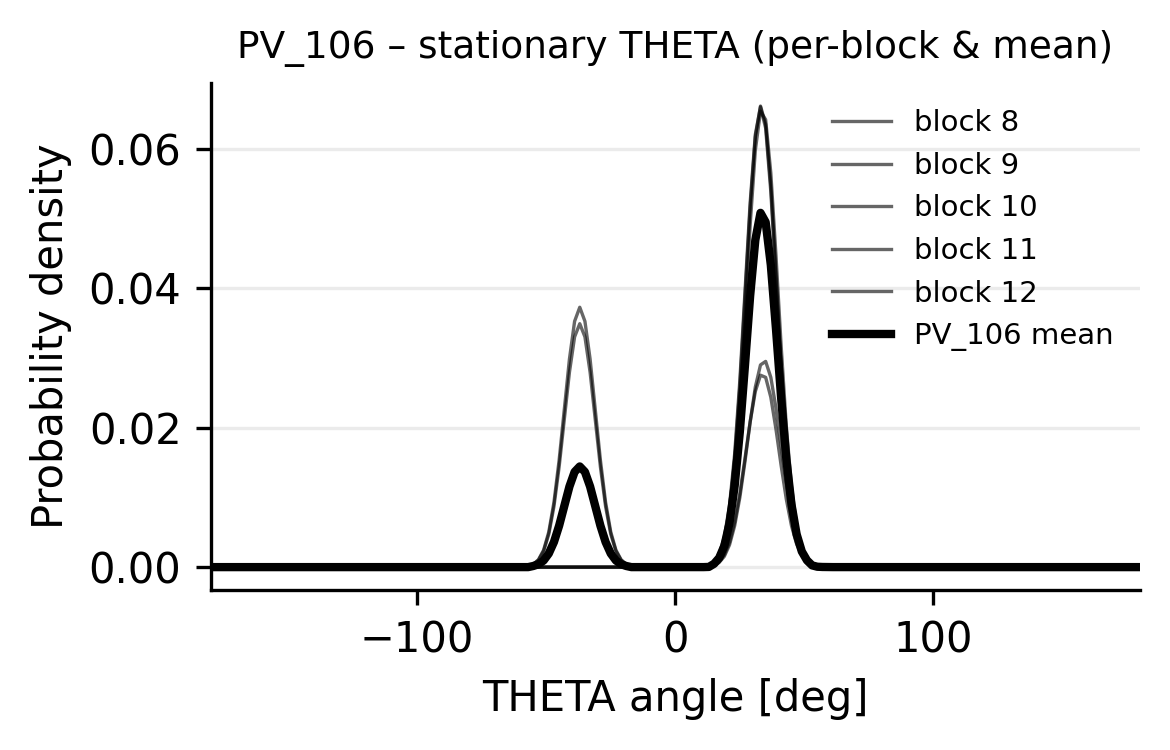

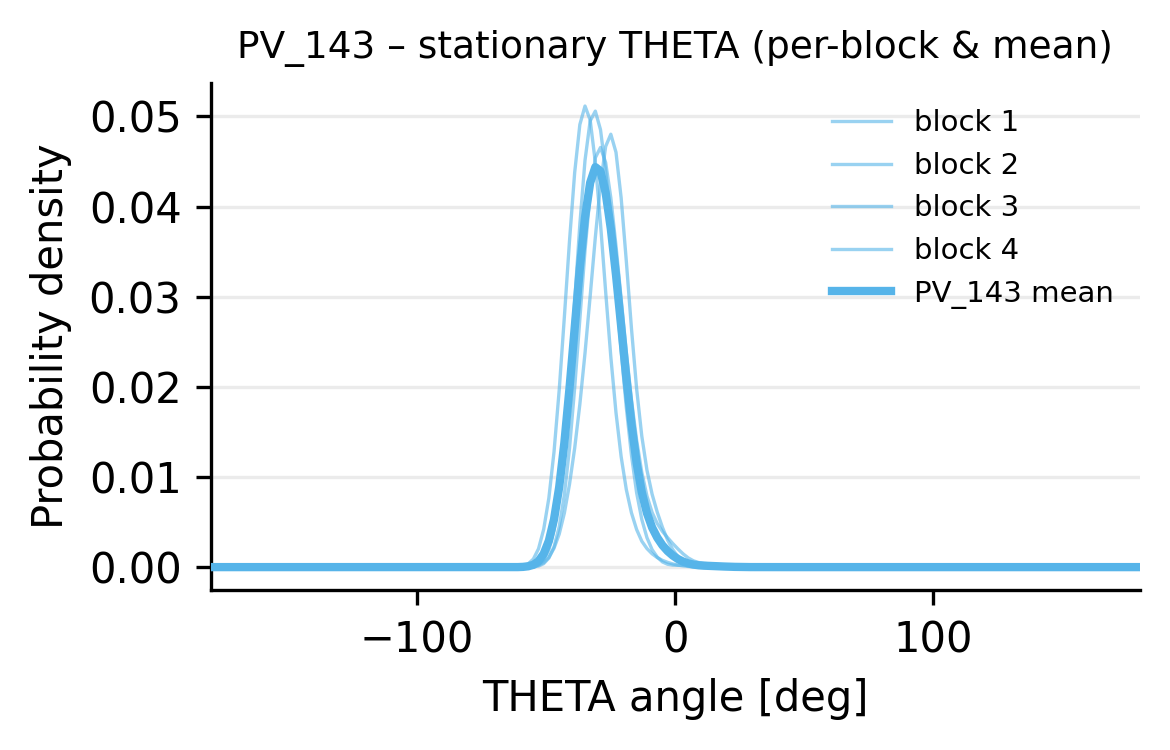

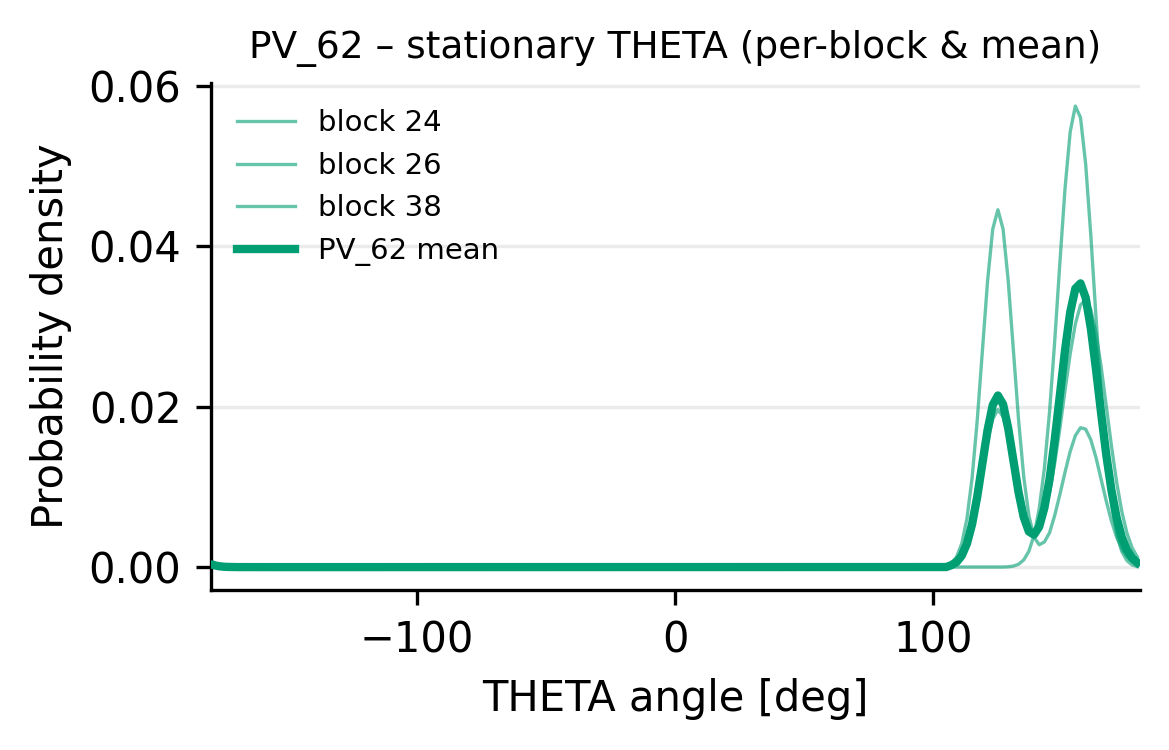

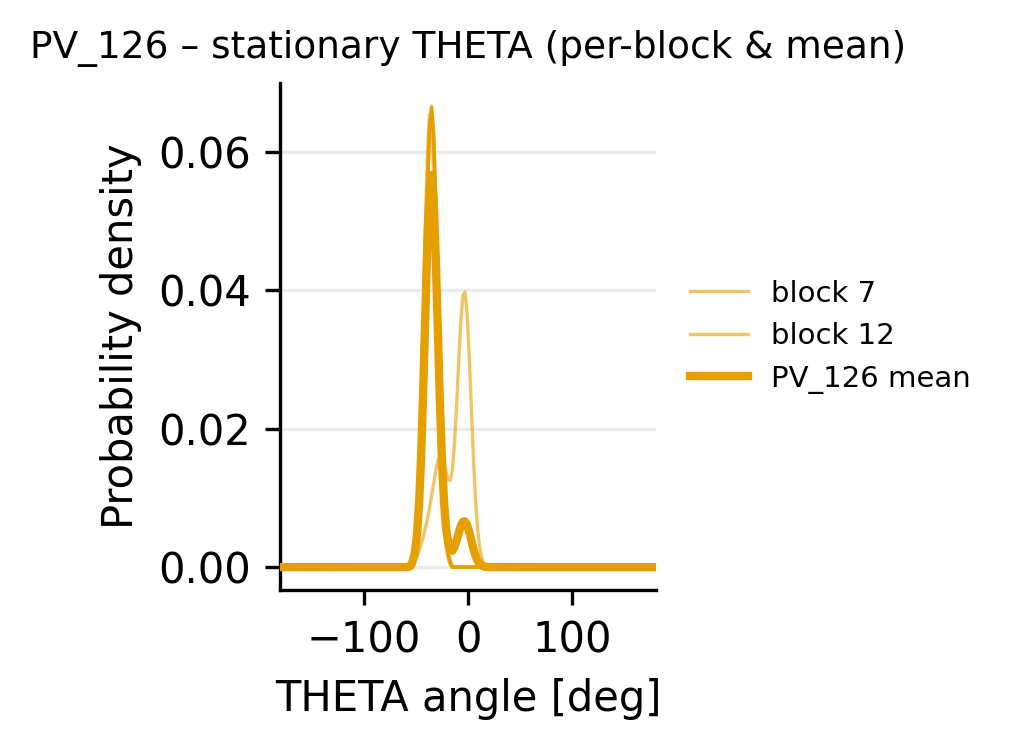

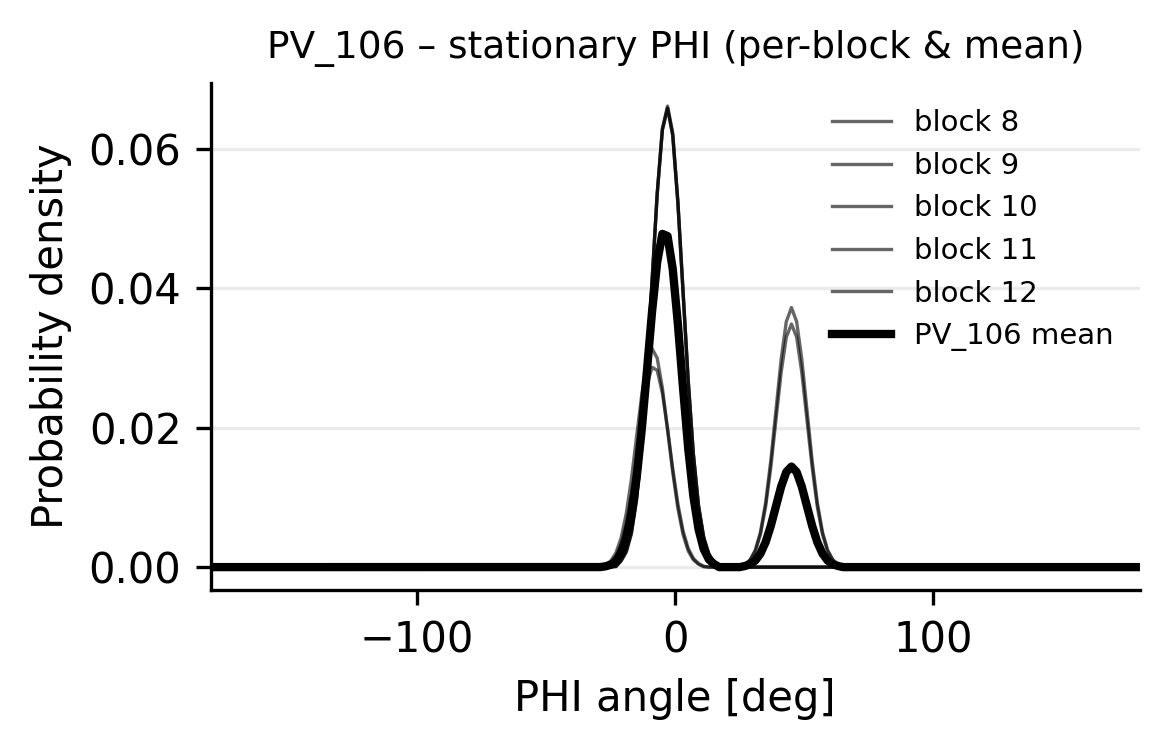

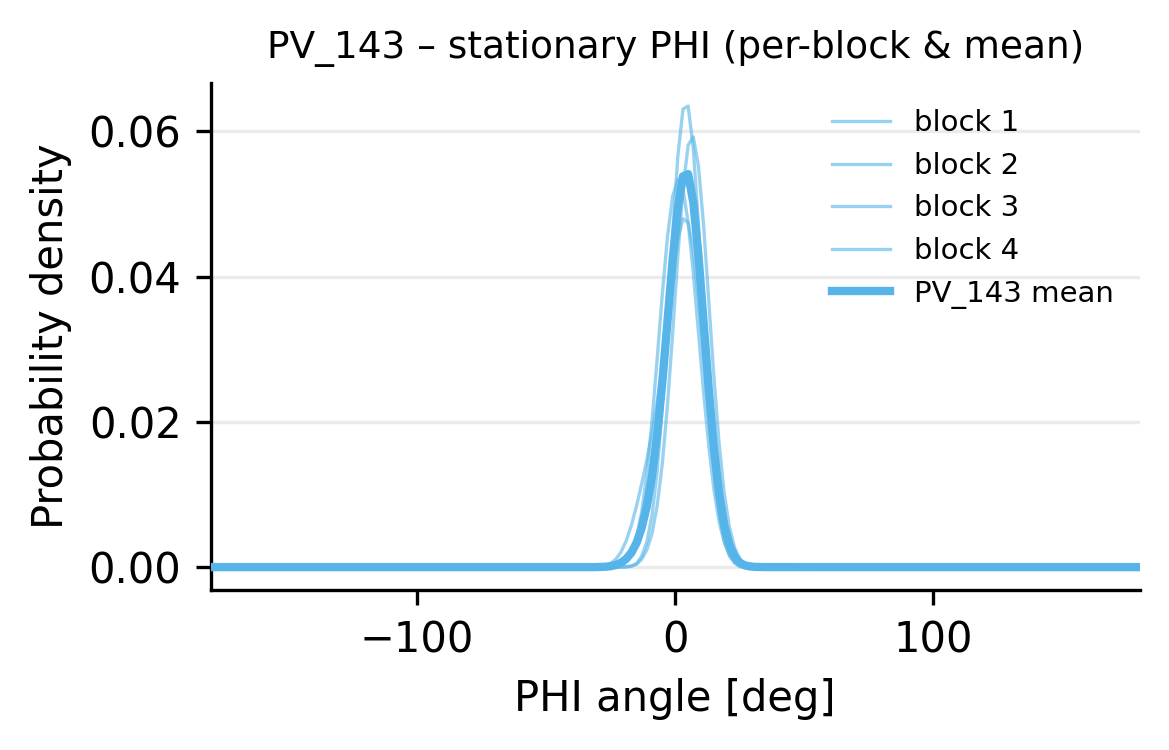

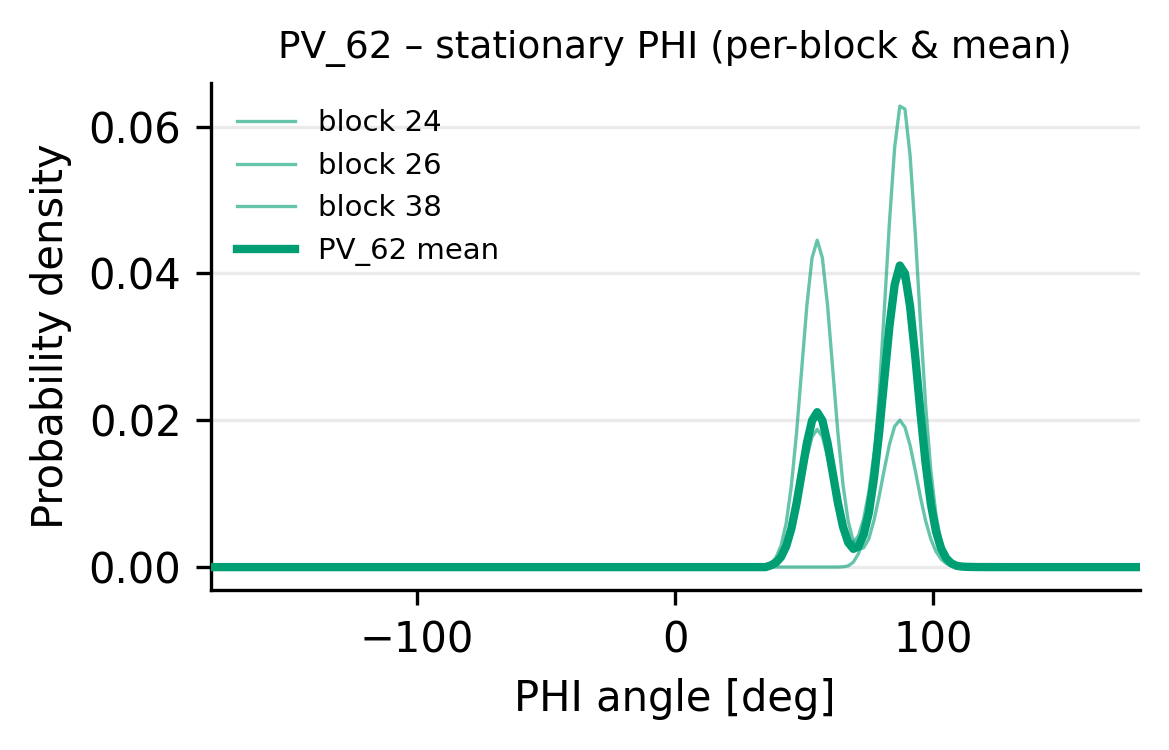

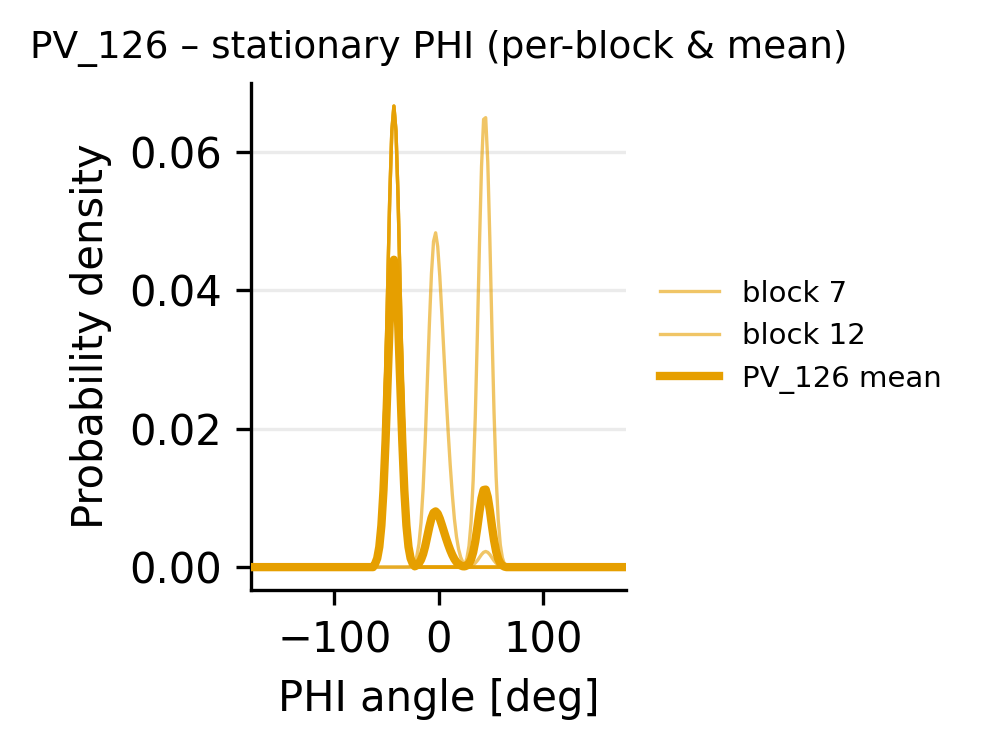

In [28]:
# ========= Stationary angle distributions: per-block & per-animal =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, pathlib, pickle
from typing import Dict, List, Tuple, Optional

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

# Color template (override via colors=... if you have GLOBAL_COLORS)
OKABE_ITO = ["#000000","#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7"]

# ----------------------- helpers (circular & hist) -----------------------
def _wrap_to_range(angles_deg: np.ndarray, low: float, high: float) -> np.ndarray:
    w = high - low
    return (angles_deg - low) % w + low

def circ_mean_deg(a_deg: np.ndarray, domain: Tuple[float,float]=(-180,180)) -> float:
    """
    Circular mean in degrees over a given domain.
    """
    if a_deg.size == 0:
        return np.nan
    a_wrapped = _wrap_to_range(a_deg, domain[0], domain[1])
    # map to [0, 2π)
    a_rad = np.deg2rad(_wrap_to_range(a_wrapped, 0.0, 360.0))
    C = np.nanmean(np.cos(a_rad))
    S = np.nanmean(np.sin(a_rad))
    mu = np.arctan2(S, C)  # [-π, π]
    mu_deg = np.rad2deg(mu)
    # return in requested domain
    return _wrap_to_range(np.array([mu_deg]), domain[0], domain[1])[0]

def _circular_hist_pdf(
    angles_deg: np.ndarray,
    n_bins: int = 180,
    domain: Tuple[float,float]=(-180.0,180.0),
    smoothing_sigma_deg: Optional[float]=6.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Circular histogram -> probability density (area=1) with optional circular Gaussian smoothing.
    """
    centers = np.linspace(domain[0], domain[1], n_bins, endpoint=False) + (domain[1]-domain[0])/n_bins/2.0
    if angles_deg is None or len(angles_deg)==0:
        return centers, np.zeros_like(centers)

    ang = _wrap_to_range(np.asarray(angles_deg, float), domain[0], domain[1])
    counts, edges = np.histogram(ang, bins=n_bins, range=domain)
    bin_w = (domain[1]-domain[0]) / n_bins
    pdf = counts.astype(float) / (counts.sum() * bin_w) if counts.sum()>0 else np.zeros_like(centers)

    # circular smoothing (wrap-safe) by FFT of a Gaussian kernel
    if smoothing_sigma_deg and smoothing_sigma_deg>0:
        sigma_bins = smoothing_sigma_deg / bin_w
        half_w = int(max(1, np.ceil(3*sigma_bins)))
        kx = np.arange(-half_w, half_w+1, dtype=float)
        ker = np.exp(-0.5*(kx/sigma_bins)**2); ker /= ker.sum()
        # embed ker on circle length n_bins centered at 0
        ker_full = np.zeros_like(pdf)
        for i, val in enumerate(ker):
            idx = (i - half_w) % len(pdf)
            ker_full[idx] = val
        pdf = np.real(np.fft.ifft(np.fft.fft(pdf)*np.fft.fft(ker_full)))
        pdf[pdf<0] = 0
        pdf /= (pdf.sum()*bin_w + 1e-12)
    return centers, pdf

# ----------------------- data collection -----------------------
def collect_stationary_by_block(block_collection) -> Dict[str, Dict[int, Dict[str, np.ndarray]]]:
    """
    Returns: dict[animal][block_num] -> {'phi_deg': np.ndarray, 'theta_deg': np.ndarray}
    Only includes blocks with non-empty liz_static_df having those columns.
    """
    out: Dict[str, Dict[int, Dict[str, np.ndarray]]] = {}
    for b in block_collection:
        if not hasattr(b, "liz_static_df"):
            continue
        df = b.liz_static_df
        if df is None or len(df)==0 or not {"phi_deg","theta_deg"}.issubset(df.columns):
            continue
        animal = getattr(b, "animal_call", "UNKNOWN")
        block  = int(getattr(b, "block_num", -1))
        if animal not in out:
            out[animal] = {}
        out[animal][block] = {
            "phi_deg":   pd.to_numeric(df["phi_deg"], errors="coerce").dropna().to_numpy(),
            "theta_deg": pd.to_numeric(df["theta_deg"], errors="coerce").dropna().to_numpy()
        }
    return out

# ----------------------- plotting (per animal, per block) -----------------------
def plot_per_animal_per_block_histograms(
    block_collection,
    angle: str = "theta",                 # 'phi' or 'theta'
    n_bins: int = 180,
    domain: Tuple[float,float]=(-180,180),
    smoothing_sigma_deg: float = 6.0,
    colors: Optional[Dict[str,str]]=None, # e.g., GLOBAL_COLORS
    lw_block: float = 0.8,
    lw_mean: float = 2.0,
    alpha_block: float = 0.6,
    figsize: Tuple[float,float]=(4.0,2.6),
    export_path: Optional[pathlib.Path]=None
):
    """
    For each animal, draw a figure with all per-block PDFs (thin) and the animal mean PDF (bold).
    Exports one PDF per animal if export_path is set.
    """
    angle_key = {"phi":"phi_deg","theta":"theta_deg"}[angle.lower()]
    data = collect_stationary_by_block(block_collection)
    if not data:
        raise ValueError("No usable stationary data found.")

    # choose colors for animals
    if colors is None:
        animals_sorted = sorted(list(data.keys()))
        colors = {a: OKABE_ITO[i % len(OKABE_ITO)] for i,a in enumerate(animals_sorted)}

    # per animal plots
    bundles = {}
    ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    if export_path is not None:
        export_path = pathlib.Path(export_path); export_path.mkdir(parents=True, exist_ok=True)

    for animal, blocks in data.items():
        if not blocks:
            continue
        # compute per-block PDFs
        per_block = {}
        centers_ref = None
        for block_num, d in sorted(blocks.items()):
            centers, pdf = _circular_hist_pdf(d[angle_key], n_bins=n_bins, domain=domain,
                                              smoothing_sigma_deg=smoothing_sigma_deg)
            if centers_ref is None:
                centers_ref = centers
            per_block[block_num] = pdf

        # animal mean PDF (average of PDFs, re-normalize to area=1)
        mat = np.vstack([per_block[b] for b in per_block.keys()]) if per_block else np.zeros((1,n_bins))
        pdf_mean = mat.mean(axis=0)
        bin_w = (domain[1]-domain[0]) / n_bins
        area = pdf_mean.sum()*bin_w
        if area>0:
            pdf_mean = pdf_mean/area

        # plot
        fig, ax = plt.subplots(figsize=figsize, dpi=300)
        col = colors.get(animal, "#444444")
        for block_num, pdf in per_block.items():
            ax.plot(centers_ref, pdf, color=col, alpha=alpha_block, lw=lw_block, label=f"block {block_num}")
        ax.plot(centers_ref, pdf_mean, color=col, lw=lw_mean, label=f"{animal} mean", zorder=5)

        ax.set_title(f"{animal} – stationary {angle.upper()} (per-block & mean)", fontsize=9)
        ax.set_xlabel(f"{angle.upper()} angle [deg]"); ax.set_ylabel("Probability density")
        ax.set_xlim(domain[0], domain[1]); ax.grid(True, axis="y", alpha=0.25)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        # concise legend: only mean + first/last block
        handles, labels = ax.get_legend_handles_labels()
        if len(labels)>6:
            ax.legend(handles=[handles[0], handles[-2], handles[-1]], labels=[labels[0], labels[-2], labels[-1]],
                      fontsize=7, frameon=False, loc="center left", bbox_to_anchor=(1.02,0.5))
            fig.tight_layout(rect=[0,0,0.82,1])
        else:
            ax.legend(fontsize=7, frameon=False)
            fig.tight_layout()

        # export
        if export_path is not None:
            pdf_out = export_path / f"{animal}_stationary_{angle}_per_block_{ts}.pdf"
            fig.savefig(pdf_out, format="pdf", bbox_inches="tight", dpi=300)

        # bundle
        bundles[animal] = {
            "centers_deg": centers_ref,
            "per_block_pdfs": per_block,
            "animal_mean_pdf": pdf_mean,
            "angle": angle,
            "domain": domain,
            "n_bins": n_bins,
            "smoothing_sigma_deg": smoothing_sigma_deg,
        }
    # save bundle
    if export_path is not None:
        pkl_out = export_path / f"stationary_{angle}_per_block_bundle_{ts}.pkl"
        with open(pkl_out,"wb") as f: pickle.dump(bundles,f)
        print(f"[export] Wrote bundles to {pkl_out}")
    return bundles

# ----------------------- scatter of per-block circular means -----------------------
def plot_block_centroid_scatter(
    block_collection,
    domain: Tuple[float,float]=(-180,180),
    colors: Optional[Dict[str,str]]=None,
    marker_size: float = 12.0,
    alpha: float = 0.9,
    annotate_blocks: bool = False,
    figsize: Tuple[float,float]=(3.2,3.0),
    export_path: Optional[pathlib.Path]=None
):
    """
    Scatter of per-block circular means: X = θ̄ (deg), Y = φ̄ (deg).
    Each point is (mean of stationary theta, mean of stationary phi) for one block.
    """
    data = collect_stationary_by_block(block_collection)
    if not data:
        raise ValueError("No usable stationary data found.")
    # build table
    rows = []
    for animal, blocks in data.items():
        for block_num, d in blocks.items():
            th = d["theta_deg"]; ph = d["phi_deg"]
            th_bar = circ_mean_deg(th, domain=domain)
            ph_bar = circ_mean_deg(ph, domain=domain)
            rows.append({"animal":animal, "block":block_num, "theta_mean":th_bar, "phi_mean":ph_bar, "n":len(th)})
    df = pd.DataFrame(rows).sort_values(["animal","block"])
    # colors
    if colors is None:
        animals_sorted = sorted(df["animal"].unique().tolist())
        colors = {a: OKABE_ITO[i % len(OKABE_ITO)] for i,a in enumerate(animals_sorted)}

    # plot
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    for animal, sub in df.groupby("animal"):
        ax.scatter(sub["theta_mean"], sub["phi_mean"],
                   s=marker_size, c=colors.get(animal,"#444444"), label=animal, alpha=alpha, edgecolors="none")
        if annotate_blocks:
            for _, r in sub.iterrows():
                ax.text(r["theta_mean"], r["phi_mean"], f"{int(r['block'])}", fontsize=6, ha="center", va="center")

    ax.set_xlabel("θ̄ (deg)"); ax.set_ylabel("φ̄ (deg)")
    ax.set_xlim(domain); ax.set_ylim(domain)
    ax.grid(True, alpha=0.25)
    ax.axvline(0, ls=":", lw=0.8, color="k", alpha=0.35)
    ax.axhline(0, ls=":", lw=0.8, color="k", alpha=0.35)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.legend(title="Animal", fontsize=7, title_fontsize=8, frameon=False, loc="center left", bbox_to_anchor=(1.02,0.5))
    fig.tight_layout(rect=[0,0,0.82,1])

    # export & bundle
    bundle = {"df": df, "domain": domain, "created_at": datetime.datetime.now().isoformat(timespec="seconds")}
    if export_path is not None:
        export_path = pathlib.Path(export_path); export_path.mkdir(parents=True, exist_ok=True)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        fig.savefig(export_path / f"stationary_block_centroids_{ts}.pdf", format="pdf", bbox_inches="tight", dpi=300)
        with open(export_path / f"stationary_block_centroids_{ts}.pkl","wb") as f: pickle.dump(bundle,f)
        print(f"[export] Scatter + data saved to {export_path}")
    return fig, ax, bundle

# ----------------------- example usage -----------------------
# Optional: set an export directory (or None to skip saving)
# outdir = pathlib.Path(r"Z:\Nimrod\exports\stationary_angles_by_block")
outdir = None

# Per-animal figures (separate PDFs per animal if export_path is set)
bundles_theta = plot_per_animal_per_block_histograms(
    block_collection,
    angle="theta",
    n_bins=180,
    domain=(-180,180),
    smoothing_sigma_deg=6.0,
    colors=None,               # or your GLOBAL_COLORS
    export_path=outdir
)
bundles_phi = plot_per_animal_per_block_histograms(
    block_collection,
    angle="phi",
    n_bins=180,
    domain=(-180,180),
    smoothing_sigma_deg=6.0,
    colors=None,
    export_path=outdir
)

# Scatter of per-block circular means (θ̄ vs φ̄)
fig_sc, ax_sc, bundle_sc = plot_block_centroid_scatter(
    block_collection.query('animal=="PV_143"'),
    domain=(-180,180),
    colors=None,               # or your GLOBAL_COLORS
    annotate_blocks=False,     # set True to print block numbers
    export_path=outdir
)
plt.show()


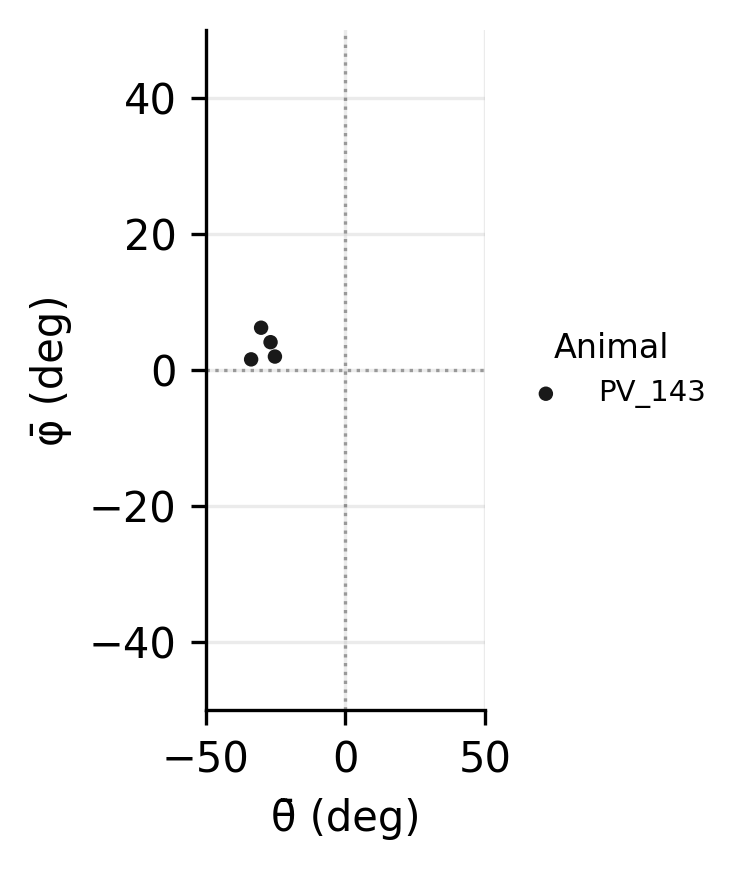

In [20]:
# Scatter of per-block circular means (θ̄ vs φ̄)
pv_143_blocks = [block for block in block_collection if block.animal_call == "PV_143"]
fig_sc, ax_sc, bundle_sc = plot_block_centroid_scatter(
    pv_143_blocks,
    domain=(-50,50),
    colors=None,               # or your GLOBAL_COLORS
    annotate_blocks=False,     # set True to print block numbers
    export_path=outdir
)
plt.show()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib, datetime, pickle
from typing import Optional, Tuple

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def heatmap_stationary_phi_theta_for_animal(
    block_collection,
    animal_call: str,
    domain_abs: int = 180,                  # heatmap covers [-domain_abs, +domain_abs] on both axes
    normalize: bool = True,                 # True -> probability density; False -> raw counts
    figsize: Tuple[float, float] = (3.2, 3.0),
    export_path: Optional[pathlib.Path] = None,
    title: Optional[str] = None
):
    """
    Build a pooled stationary φ–θ heatmap for a single animal.
    X = θ (deg), Y = φ (deg). Axes are equal. Colormap: 'turbo'.
    Binning: 1 bin per degree (i.e., bin width = 1 deg).

    Parameters
    ----------
    block_collection : iterable of BlockSync
        Must contain blocks with `liz_static_df` having columns ['phi_deg','theta_deg'].
    animal_call : str
        The animal identifier to select (compared against `block.animal_call`).
    domain_abs : int
        Symmetric angular domain limit in degrees; heatmap spans [-domain_abs, +domain_abs].
    normalize : bool
        If True, color encodes probability density (area=1). If False, raw counts.
    figsize : (w,h)
        Figure size in inches.
    export_path : pathlib.Path or None
        If set, saves a timestamped PDF and a .pkl bundle with inputs and the 2D histogram.
    title : str or None
        Optional title override.

    Returns
    -------
    fig, ax, bundle : (matplotlib Figure, Axes, dict)
        `bundle` contains bin edges, H matrix, sample size, and metadata.
    """
    # 1) Collect stationary samples for this animal
    thetas, phis, blocks_used = [], [], []
    for b in block_collection:
        if getattr(b, "animal_call", None) != animal_call:
            continue
        if not hasattr(b, "liz_static_df"):
            continue
        df = b.liz_static_df
        if df is None or len(df) == 0 or not {"phi_deg","theta_deg"}.issubset(df.columns):
            continue
        th = pd.to_numeric(df["theta_deg"], errors="coerce").dropna().to_numpy()
        ph = pd.to_numeric(df["phi_deg"],   errors="coerce").dropna().to_numpy()
        if th.size and ph.size:
            # allow different lengths within the df; use shared mask if mismatched
            n = min(th.size, ph.size)
            thetas.append(th[:n])
            phis.append(ph[:n])
            blocks_used.append(getattr(b, "block_num", None))

    if not thetas:
        raise ValueError(f"No usable stationary data for animal '{animal_call}'.")

    theta_all = np.concatenate(thetas).astype(float)
    phi_all   = np.concatenate(phis).astype(float)
    n_samples = int(min(theta_all.size, phi_all.size))

    # 2) Define symmetric domain and 1° bins
    lo, hi = -float(domain_abs), float(domain_abs)
    bin_width = 1.0  # 1 bin per degree
    edges = np.arange(lo, hi + bin_width, bin_width)  # inclusive upper edge for exact coverage

    # 3) 2D histogram (θ on x, φ on y)
    H, xedges, yedges = np.histogram2d(theta_all, phi_all, bins=[edges, edges], density=normalize)
    # Note: numpy returns H shape (len(xedges)-1, len(yedges)-1)

    # 4) Plot
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    im = ax.imshow(
        H.T,                             # transpose so y matches φ vertically
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        cmap='turbo',
        aspect='equal',
        interpolation='nearest'
    )
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_xlabel("θ (deg)", fontsize=10)
    ax.set_ylabel("φ (deg)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)

    ttl = title if title is not None else f"{animal_call} – stationary φ vs θ heatmap"
    ax.set_title(ttl, fontsize=10)

    cbar = fig.colorbar(im, ax=ax, pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Probability density" if normalize else "Count", fontsize=10)

    fig.tight_layout()

    # 5) Bundle + optional export
    bundle = {
        "animal_call": animal_call,
        "domain": (lo, hi),
        "bin_width_deg": bin_width,
        "xedges_theta": xedges,
        "yedges_phi": yedges,
        "H": H,
        "n_samples": n_samples,
        "blocks_used": blocks_used,
        "normalize": normalize,
        "created_at": datetime.datetime.now().isoformat(timespec="seconds"),
    }

    if export_path is not None:
        export_path = pathlib.Path(export_path)
        export_path.mkdir(parents=True, exist_ok=True)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        fig.savefig(export_path / f"{animal_call}_phi_theta_heatmap_{ts}.pdf",
                    format="pdf", bbox_inches="tight", dpi=300)
        with open(export_path / f"{animal_call}_phi_theta_heatmap_{ts}.pkl","wb") as f:
            pickle.dump(bundle, f)
        print(f"[export] Saved heatmap & data to {export_path}")

    return fig, ax, bundle


[export] Saved heatmap & data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\head_orientation_intan


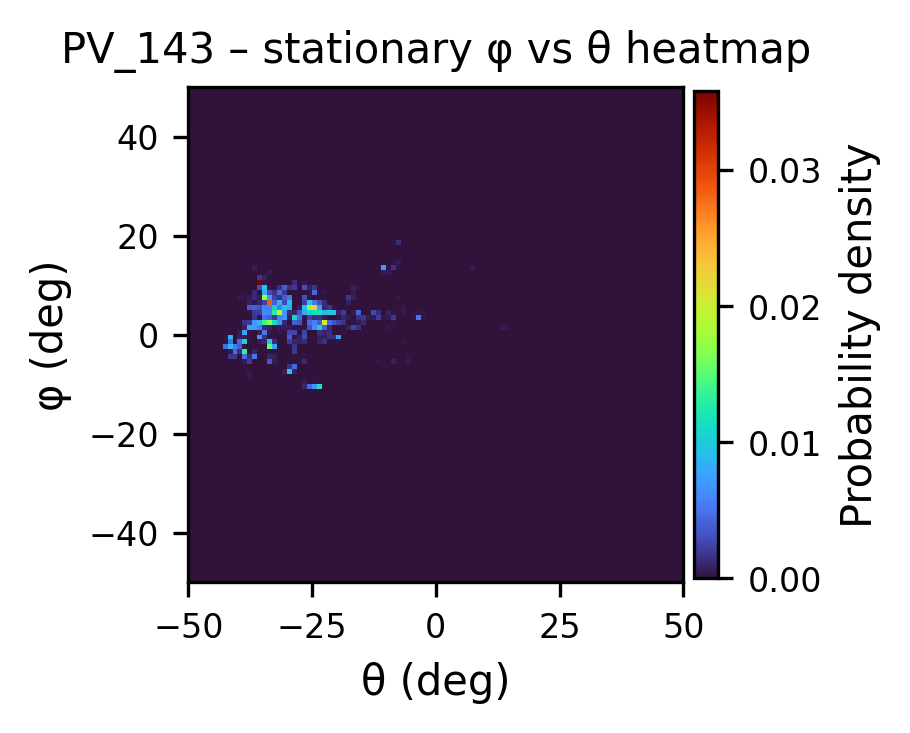

In [27]:
# Example: PV_106, ±180°, normalized PDF
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\head_orientation_intan')
fig, ax, bundle = heatmap_stationary_phi_theta_for_animal(
    block_collection,
    animal_call="PV_143",
    domain_abs=50,
    normalize=True,
    figsize=(3.2, 3.0),
    export_path=export_path  # or pathlib.Path(r"Z:\Nimrod\exports\phi_theta_heatmaps")
)
plt.show()


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib, datetime, pickle
from typing import Optional, Tuple

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def heatmap_stationary_phi_theta_for_animal(
    block_collection,
    animal_call: str,
    domain_abs: int = 180,                  # heatmap covers [-domain_abs, +domain_abs] on both axes
    normalize: bool = True,                 # True -> probability density; False -> raw counts
    figsize: Tuple[float, float] = (3.2, 3.0),
    export_path: Optional[pathlib.Path] = None,
    title: Optional[str] = None
):
    """
    Build a pooled stationary φ–θ heatmap for a single animal.
    X = θ (deg), Y = φ (deg). Axes are equal. Colormap: 'turbo'.
    Binning: 1 bin per degree (i.e., bin width = 1 deg).
    Also overlays the overall circular-mean point as a visible scatter dot.
    """

    def _circ_mean_deg(arr):
        """Circular mean in degrees (robust to wraparound)."""
        a = np.asarray(arr, float)
        a = a[np.isfinite(a)]
        if a.size == 0:
            return np.nan
        C = np.nanmean(np.cos(np.deg2rad(a)))
        S = np.nanmean(np.sin(np.deg2rad(a)))
        return np.rad2deg(np.arctan2(S, C))

    # 1) Collect stationary samples for this animal
    thetas, phis, blocks_used = [], [], []
    for b in block_collection:
        if getattr(b, "animal_call", None) != animal_call:
            continue
        if not hasattr(b, "liz_static_df"):
            continue
        df = b.liz_static_df
        if df is None or len(df) == 0 or not {"phi_deg","theta_deg"}.issubset(df.columns):
            continue
        th = pd.to_numeric(df["theta_deg"], errors="coerce").dropna().to_numpy()
        ph = pd.to_numeric(df["phi_deg"],   errors="coerce").dropna().to_numpy()
        if th.size and ph.size:
            n = min(th.size, ph.size)
            thetas.append(th[:n])
            phis.append(ph[:n])
            blocks_used.append(getattr(b, "block_num", None))

    if not thetas:
        raise ValueError(f"No usable stationary data for animal '{animal_call}'.")

    theta_all = np.concatenate(thetas).astype(float)
    phi_all   = np.concatenate(phis).astype(float)
    n_samples = int(min(theta_all.size, phi_all.size))

    # 2) Define symmetric domain and 1° bins
    lo, hi = -float(domain_abs), float(domain_abs)
    bin_width = 1.0  # 1 bin per degree
    edges = np.arange(lo, hi + bin_width, bin_width)  # inclusive upper edge for exact coverage

    # 3) 2D histogram (θ on x, φ on y)
    H, xedges, yedges = np.histogram2d(theta_all, phi_all, bins=[edges, edges], density=normalize)

    # 4) Plot heatmap
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    im = ax.imshow(
        H.T,  # transpose so y matches φ vertically
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        cmap='turbo',
        aspect='equal',
        interpolation='nearest'
    )
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_xlabel("θ (deg)", fontsize=10)
    ax.set_ylabel("φ (deg)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)

    ttl = title if title is not None else f"{animal_call} – stationary φ vs θ heatmap"
    ax.set_title(ttl, fontsize=10)

    cbar = fig.colorbar(im, ax=ax, pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Probability density" if normalize else "Count", fontsize=10)

    # 4b) Overlay overall average (circular mean)
    mean_theta = _circ_mean_deg(theta_all)
    mean_phi   = _circ_mean_deg(phi_all)
    if np.isfinite(mean_theta) and np.isfinite(mean_phi):
        ax.scatter(mean_theta, mean_phi,
                   marker='o', s=10, c='white', edgecolors='black',
                   linewidths=0.7, zorder=1)

    fig.tight_layout()

    # 5) Bundle + optional export
    bundle = {
        "animal_call": animal_call,
        "domain": (lo, hi),
        "bin_width_deg": bin_width,
        "xedges_theta": xedges,
        "yedges_phi": yedges,
        "H": H,
        "n_samples": n_samples,
        "blocks_used": blocks_used,
        "normalize": normalize,
        "mean_theta_deg_circular": float(mean_theta),
        "mean_phi_deg_circular": float(mean_phi),
        "created_at": datetime.datetime.now().isoformat(timespec="seconds"),
    }

    if export_path is not None:
        export_path = pathlib.Path(export_path)
        export_path.mkdir(parents=True, exist_ok=True)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        fig.savefig(export_path / f"{animal_call}_phi_theta_heatmap_{ts}.pdf",
                    format="pdf", bbox_inches="tight", dpi=300)
        with open(export_path / f"{animal_call}_phi_theta_heatmap_{ts}.pkl","wb") as f:
            pickle.dump(bundle, f)
        print(f"[export] Saved heatmap & data to {export_path}")

    return fig, ax, bundle,


[export] Saved heatmap & data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\head_orientation_intan


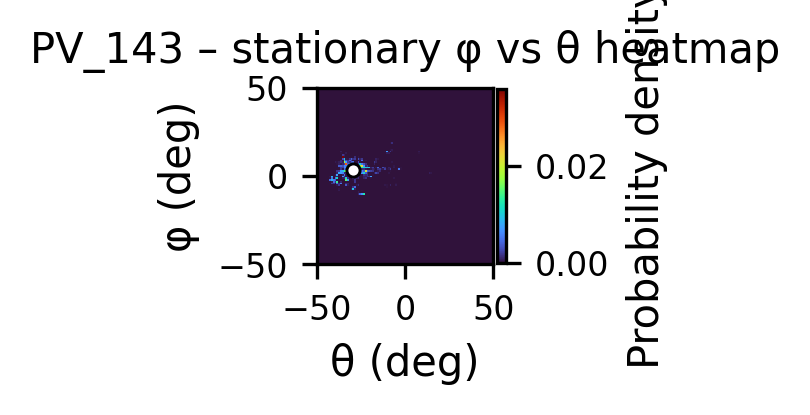

In [47]:

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\head_orientation_intan')
heatmap_stationary_phi_theta_for_animal(
    block_collection, animal_call='PV_143',
    domain_abs=50,
    export_path=export_path,
    figsize=(2,2.3))
plt.show()


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pathlib, datetime, pickle
from typing import Optional, Tuple

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def heatmap_stationary_phi_theta_for_animal(
    block_collection,
    animal_call: str,
    domain_abs: int = 180,                  # fallback domain if auto_zoom=False
    normalize: bool = True,                 # True -> probability density; False -> counts
    figsize: Tuple[float, float] = (3.2, 3.0),
    export_path: Optional[pathlib.Path] = None,
    title: Optional[str] = None,
    # --- smart zoom controls ---
    auto_zoom: bool = True,
    zoom_method: str = "percentile",        # "percentile" | "iqr" | "max"
    zoom_percentile: float = 99.5,          # used if zoom_method == "percentile"
    zoom_pad_deg: float = 5.0,              # extra padding beyond estimated extent
    min_domain_abs: float = 10.0,           # don't zoom tighter than this
    max_domain_abs: float = 180.0           # never exceed this
):
    """
    Pooled stationary φ–θ heatmap for a single animal.
    X = θ (deg), Y = φ (deg). Axes equal, turbo colormap, 1° bins.
    Auto-zooms to a robust symmetric ±domain based on data (toggle via auto_zoom).
    Overlays the overall circular-mean point with a tiny text label.
    """

    def _circ_mean_deg(arr):
        a = np.asarray(arr, float)
        a = a[np.isfinite(a)]
        if a.size == 0:
            return np.nan
        C = np.nanmean(np.cos(np.deg2rad(a)))
        S = np.nanmean(np.sin(np.deg2rad(a)))
        return np.rad2deg(np.arctan2(S, C))

    # 1) collect stationary θ/φ
    thetas, phis, blocks_used = [], [], []
    for b in block_collection:
        if getattr(b, "animal_call", None) != animal_call:
            continue
        if not hasattr(b, "liz_static_df"):
            continue
        df = b.liz_static_df
        if df is None or len(df) == 0 or not {"phi_deg","theta_deg"}.issubset(df.columns):
            continue
        th = pd.to_numeric(df["theta_deg"], errors="coerce").dropna().to_numpy()
        ph = pd.to_numeric(df["phi_deg"],   errors="coerce").dropna().to_numpy()
        if th.size and ph.size:
            n = min(th.size, ph.size)
            thetas.append(th[:n]); phis.append(ph[:n])
            blocks_used.append(getattr(b, "block_num", None))

    if not thetas:
        raise ValueError(f"No usable stationary data for animal '{animal_call}'.")

    theta_all = np.concatenate(thetas).astype(float)
    phi_all   = np.concatenate(phis).astype(float)
    n_samples = int(min(theta_all.size, phi_all.size))

    # 2) auto-zoom domain (symmetric ±X), robust to outliers
    if auto_zoom:
        if zoom_method.lower() == "percentile":
            th_ext = np.nanpercentile(np.abs(theta_all), zoom_percentile)
            ph_ext = np.nanpercentile(np.abs(phi_all),   zoom_percentile)
        elif zoom_method.lower() == "iqr":
            def extent_iqr(x, k=3.0):
                x = x[np.isfinite(x)]
                if x.size == 0: return 0.0
                q1, q3 = np.percentile(x, [25, 75]); iqr = q3 - q1
                lo = q1 - k*iqr; hi = q3 + k*iqr
                return max(abs(lo), abs(hi))
            th_ext, ph_ext = extent_iqr(theta_all), extent_iqr(phi_all)
        else:  # "max"
            th_ext, ph_ext = np.nanmax(np.abs(theta_all)), np.nanmax(np.abs(phi_all))

        dom = max(th_ext, ph_ext) + float(zoom_pad_deg)
        dom = float(np.ceil(dom))                         # align to 1°
        dom = max(min_domain_abs, min(max_domain_abs, dom))
        domain_use = int(dom)
    else:
        domain_use = int(domain_abs)

    lo, hi = -float(domain_use), float(domain_use)

    # 3) histogram with 1° bins
    edges = np.arange(lo, hi + 1.0, 1.0)  # inclusive upper edge
    H, xedges, yedges = np.histogram2d(theta_all, phi_all, bins=[edges, edges], density=normalize)

    # 4) plot
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    im = ax.imshow(
        H.T, origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        cmap='turbo', aspect='equal', interpolation='nearest'
    )
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_xlabel("θ (deg)", fontsize=10)
    ax.set_ylabel("φ (deg)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)

    ttl = title if title is not None else f"{animal_call} – stationary φ vs θ heatmap"
    ax.set_title(ttl, fontsize=10)

    cbar = fig.colorbar(im, ax=ax, pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Probability density" if normalize else "Count", fontsize=10)

    # 4b) circular-mean marker + tiny label
    mean_theta = _circ_mean_deg(theta_all)
    mean_phi   = _circ_mean_deg(phi_all)
    if np.isfinite(mean_theta) and np.isfinite(mean_phi):
        ax.scatter(mean_theta, mean_phi, marker='X', s=48, c='white',
                   edgecolors='black', linewidths=0.7, zorder=3)
        txt = f"θ̄={mean_theta:.1f}°, φ̄={mean_phi:.1f}°"
        # offset label a bit; flip to left if near right edge
        margin = 0.1*(hi - lo)
        dx, ha = (-6, 'right') if mean_theta > hi - margin else (6, 'left')
        ax.annotate(txt, (mean_theta, mean_phi), xytext=(dx, 6), textcoords='offset points',
                    fontsize=8, color='white',
                    path_effects=[pe.withStroke(linewidth=2, foreground='black')],
                    ha=ha, va='bottom')

    fig.tight_layout()

    # 5) bundle + optional export
    bundle = {
        "animal_call": animal_call,
        "domain_used": (lo, hi),
        "auto_zoom": auto_zoom,
        "zoom_method": zoom_method,
        "zoom_percentile": zoom_percentile,
        "zoom_pad_deg": zoom_pad_deg,
        "xedges_theta": xedges,
        "yedges_phi": yedges,
        "H": H,
        "n_samples": n_samples,
        "blocks_used": blocks_used,
        "normalize": normalize,
        "mean_theta_deg_circular": float(mean_theta),
        "mean_phi_deg_circular": float(mean_phi),
        "created_at": datetime.datetime.now().isoformat(timespec="seconds"),
    }

    if export_path is not None:
        export_path = pathlib.Path(export_path)
        export_path.mkdir(parents=True, exist_ok=True)
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        fig.savefig(export_path / f"{animal_call}_phi_theta_heatmap_{ts}.pdf",
                    format="pdf", bbox_inches="tight", dpi=300)
        with open(export_path / f"{animal_call}_phi_theta_heatmap_{ts}.pkl","wb") as f:
            pickle.dump(bundle, f)
        print(f"[export] Saved heatmap & data to {export_path}")

    return fig, ax, bundle


[export] Saved heatmap & data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\head_orientation_intan


(<Figure size 960x900 with 2 Axes>,
 <Axes: title={'center': 'PV_143 – stationary φ vs θ heatmap'}, xlabel='θ (deg)', ylabel='φ (deg)'>,
 {'animal_call': 'PV_143',
  'domain_used': (-49.0, 49.0),
  'auto_zoom': True,
  'zoom_method': 'max',
  'zoom_percentile': 99.5,
  'zoom_pad_deg': 5.0,
  'xedges_theta': array([-49., -48., -47., -46., -45., -44., -43., -42., -41., -40., -39.,
         -38., -37., -36., -35., -34., -33., -32., -31., -30., -29., -28.,
         -27., -26., -25., -24., -23., -22., -21., -20., -19., -18., -17.,
         -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
          -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
           6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
          17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
          28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
          39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.]),
  'yedges_phi': 

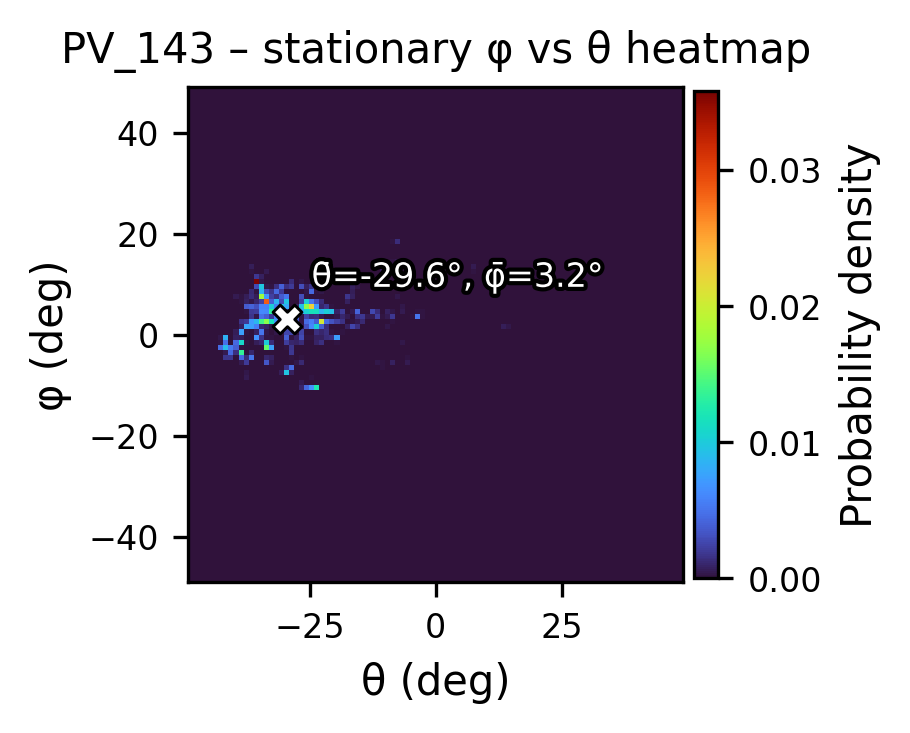

In [52]:
heatmap_stationary_phi_theta_for_animal(block_collection,
                                        animal_call='PV_143',
                                        auto_zoom=True,zoom_method='max',
                                        export_path=export_path)